### This notebook shows how to create a correlation map for stocks in S&P 500 index

In [65]:
# Import libraries
import bs4 as bs
import pickle
import requests
import datetime as dt
import os #create new directories
import pandas_datareader as web
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np

In [38]:
# Create function to get S&P 50 tickers from wikipedia
def save_sp500_tickers():
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text)
    table = soup.find('table',{'class':'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker)
        
    with open('sp500tickers.pickle','wb') as f:
        pickle.dump(tickers,f)
        
    print(tickers)
    
    return tickers

In [39]:
save_sp500_tickers()

C:\Users\Biarys\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\Biarys\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "html.parser")

  markup_type=markup_type))


['MMM', 'ABT', 'ABBV', 'ACN', 'ATVI', 'AYI', 'ADBE', 'AMD', 'AAP', 'AES', 'AET', 'AMG', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALXN', 'ALGN', 'ALLE', 'AGN', 'ADS', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'APC', 'ADI', 'ANDV', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'AIV', 'AAPL', 'AMAT', 'ADM', 'ARNC', 'AJG', 'AIZ', 'T', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'BHGE', 'BLL', 'BAC', 'BK', 'BCR', 'BAX', 'BBT', 'BDX', 'BRK.B', 'BBY', 'BIIB', 'BLK', 'HRB', 'BA', 'BWA', 'BXP', 'BSX', 'BHF', 'BMY', 'AVGO', 'BF.B', 'CHRW', 'CA', 'COG', 'CDNS', 'CPB', 'COF', 'CAH', 'CBOE', 'KMX', 'CCL', 'CAT', 'CBG', 'CBS', 'CELG', 'CNC', 'CNP', 'CTL', 'CERN', 'CF', 'SCHW', 'CHTR', 'CHK', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'XEC', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CTXS', 'CLX', 'CME', 'CMS', 'COH', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'CXO', 'COP', 'ED', 'STZ', 'COO', 'GLW', 'COST', 'COTY', 'CCI', 'CSRA', 'CSX', 

['MMM',
 'ABT',
 'ABBV',
 'ACN',
 'ATVI',
 'AYI',
 'ADBE',
 'AMD',
 'AAP',
 'AES',
 'AET',
 'AMG',
 'AFL',
 'A',
 'APD',
 'AKAM',
 'ALK',
 'ALB',
 'ARE',
 'ALXN',
 'ALGN',
 'ALLE',
 'AGN',
 'ADS',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AEE',
 'AAL',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'ABC',
 'AME',
 'AMGN',
 'APH',
 'APC',
 'ADI',
 'ANDV',
 'ANSS',
 'ANTM',
 'AON',
 'AOS',
 'APA',
 'AIV',
 'AAPL',
 'AMAT',
 'ADM',
 'ARNC',
 'AJG',
 'AIZ',
 'T',
 'ADSK',
 'ADP',
 'AZO',
 'AVB',
 'AVY',
 'BHGE',
 'BLL',
 'BAC',
 'BK',
 'BCR',
 'BAX',
 'BBT',
 'BDX',
 'BRK.B',
 'BBY',
 'BIIB',
 'BLK',
 'HRB',
 'BA',
 'BWA',
 'BXP',
 'BSX',
 'BHF',
 'BMY',
 'AVGO',
 'BF.B',
 'CHRW',
 'CA',
 'COG',
 'CDNS',
 'CPB',
 'COF',
 'CAH',
 'CBOE',
 'KMX',
 'CCL',
 'CAT',
 'CBG',
 'CBS',
 'CELG',
 'CNC',
 'CNP',
 'CTL',
 'CERN',
 'CF',
 'SCHW',
 'CHTR',
 'CHK',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'XEC',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CTXS',
 'CLX',
 'CME',
 'CMS',
 'COH',
 

In [10]:
# Getting data from Yahoo for all the tickers
# Skips in the case if the ticker is wrong/does not exist
def get_data_from_yahoo(reload_sp500 = False):
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        with open('sp500tickers.pickle','rb') as f:
            tickers = pickle.load(f)
            
    if not os.path.exists('stock_dfs'):  #if path does not exist
        os.makedirs('stock_dfs')         #create a path
        
    start = dt.datetime(2000,1,1)
    end = dt.datetime(2016,12,31)
    
    for ticker in tickers:
        print(ticker)
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            try:
                df = web.DataReader(ticker, 'yahoo', start, end)
                df.to_csv('stock_dfs/{}.csv'.format(ticker))
            except:
                pass
        else:
            print("Already have {}".format(ticker))

In [11]:
get_data_from_yahoo()

MMM
Already have MMM
ABT
Already have ABT
ABBV
Already have ABBV
ACN
Already have ACN
ATVI
Already have ATVI
AYI
Already have AYI
ADBE
Already have ADBE
AMD
Already have AMD
AAP
Already have AAP
AES
Already have AES
AET
Already have AET
AMG
Already have AMG
AFL
Already have AFL
A
Already have A
APD
Already have APD
AKAM
Already have AKAM
ALK
Already have ALK
ALB
Already have ALB
ARE
Already have ARE
ALXN
ALGN
ALLE
AGN
ADS
LNT
ALL
GOOGL
GOOG
MO
AMZN
AEE
AAL
AEP
AXP
AIG
AMT
AWK
AMP
ABC
AME
AMGN
APH
APC
ADI
ANDV
ANSS
ANTM
AON
AOS
APA
AIV
AAPL
AMAT
ADM
ARNC
AJG
AIZ
T
ADSK
ADP
AZO
AVB
AVY
BHGE
BLL
BAC
BK
BCR
BAX
BBT
BDX
BRK.B
BBY
BIIB
BLK
HRB
BA
BWA
BXP
BSX
BHF
BMY
AVGO
BF.B
CHRW
CA
COG
CDNS
CPB
COF
CAH
CBOE
KMX
CCL
CAT
CBG
CBS
CELG
CNC
CNP
CTL
CERN
CF
SCHW
CHTR
CHK
CVX
CMG
CB
CHD
CI
XEC
CINF
CTAS
CSCO
C
CFG
CTXS
CLX
CME
CMS
COH
KO
CTSH
CL
CMCSA
CMA
CAG
CXO
COP
ED
STZ
COO
GLW
COST
COTY
CCI
CSRA
CSX
CMI
CVS
DHI
DHR
DRI
DVA
DE
DLPH
DAL
XRAY
DVN
DLR
DFS
DISCA
DISCK
DISH
DG
DLTR
D
DOV
DWDP
DPS


In [41]:
# Aggregating all the data into 1 data frame
def compile_data():
    with open('sp500tickers.pickle','rb') as f: #use the latest updated ticker file to avoid removed stocks, etc...
        tickers = pickle.load(f)
        
    main_df = pd.DataFrame()
    
    for count, ticker in enumerate(tickers):
        try:
            df = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
            df.set_index('Date', inplace=True)
        
        
            df.rename(columns = {'Adj Close': ticker}, inplace = True)
            df.drop(['Open','High','Low','Close','Volume'], 1, inplace = True)
        
            if main_df.empty: #if empty
                main_df = df  #create first column
            else:
                main_df = main_df.join(df, how = 'outer') #use date as key, add everything else
        except:
            pass    
        print(ticker)
            
    print(main_df.head())
    main_df.to_csv('sp500_joined_closes.csv')

In [42]:
compile_data()

MMM
ABT
ABBV
ACN
ATVI
AYI
ADBE
AMD
AAP
AES
AET
AMG
AFL
A
APD
AKAM
ALK
ALB
ARE
ALXN
ALGN
ALLE
AGN
ADS
LNT
ALL
GOOGL
GOOG
MO
AMZN
AEE
AAL
AEP
AXP
AIG
AMT
AWK
AMP
ABC
AME
AMGN
APH
APC
ADI
ANDV
ANSS
ANTM
AON
AOS
APA
AIV
AAPL
AMAT
ADM
ARNC
AJG
AIZ
T
ADSK
ADP
AZO
AVB
AVY
BHGE
BLL
BAC
BK
BCR
BAX
BBT
BDX
BRK.B
BBY
BIIB
BLK
HRB
BA
BWA
BXP
BSX
BHF
BMY
AVGO
BF.B
CHRW
CA
COG
CDNS
CPB
COF
CAH
CBOE
KMX
CCL
CAT
CBG
CBS
CELG
CNC
CNP
CTL
CERN
CF
SCHW
CHTR
CHK
CVX
CMG
CB
CHD
CI
XEC
CINF
CTAS
CSCO
C
CFG
CTXS
CLX
CME
CMS
COH
KO
CTSH
CL
CMCSA
CMA
CAG
CXO
COP
ED
STZ
COO
GLW
COST
COTY
CCI
CSRA
CSX
CMI
CVS
DHI
DHR
DRI
DVA
DE
DLPH
DAL
XRAY
DVN
DLR
DFS
DISCA
DISCK
DISH
DG
DLTR
D
DOV
DWDP
DPS
DTE
DRE
DUK
DXC
ETFC
EMN
ETN
EBAY
ECL
EIX
EW
EA
EMR
ETR
EVHC
EOG
EQT
EFX
EQIX
EQR
ESS
EL
ES
RE
EXC
EXPE
EXPD
ESRX
EXR
XOM
FFIV
FB
FAST
FRT
FDX
FIS
FITB
FE
FISV
FLIR
FLS
FLR
FMC
FL
F
FTV
FBHS
BEN
FCX
GPS
GRMN
IT
GD
GE
GGP
GIS
GM
GPC
GILD
GPN
GS
GT
GWW
HAL
HBI
HOG
HRS
HIG
HAS
HCA
HCP
HP
HSIC
HSY
HES
HPE
HLT
HOLX
HD
HON
HRL
HS

In [49]:
# Creating a heatmap for all 500 stocks
def visualize_data():
    df = pd.read_csv("sp500_joined_closes.csv")
    df_corr = df.corr()
    
    print(df_corr.head())
    
    data = df_corr.values
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    heatmap = ax.pcolor(data, cmap = plt.cm.RdYlGn)
    fig.colorbar(heatmap)
    ax.set_xticks(np.arange(data.shape[0]) + 0.5, minor = False)
    ax.set_yticks(np.arange(data.shape[1]) + 0.5, minor = False)
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    
    column_labels = df_corr.columns
    row_labels = df_corr.index
    
    ax.set_xticklabels(column_labels)
    ax.set_yticklabels(row_labels)
    plt.xticks(rotation = 90)
    heatmap.set_clim(-1, 1)
    plt.tight_layout()
    plt.show()

           MMM       ABT      ABBV       ACN      ATVI       AYI      ADBE  \
MMM   1.000000  0.947107  0.917590  0.966734  0.926806  0.962077  0.931898   
ABT   0.947107  1.000000  0.870608  0.953740  0.890623  0.903148  0.888509   
ABBV  0.917590  0.870608  1.000000  0.782810  0.740370  0.831226  0.868343   
ACN   0.966734  0.953740  0.782810  1.000000  0.939226  0.959037  0.924770   
ATVI  0.926806  0.890623  0.740370  0.939226  1.000000  0.966880  0.939472   

           AMD       AAP       AES    ...          WYN      WYNN       XEL  \
MMM  -0.517663  0.967155 -0.281273    ...     0.936681  0.682478  0.942214   
ABT  -0.584959  0.956129 -0.223817    ...     0.958317  0.743091  0.944224   
ABBV  0.188658  0.896813  0.056811    ...     0.773404 -0.299059  0.786756   
ACN  -0.511405  0.963566  0.040392    ...     0.915648  0.683490  0.980613   
ATVI -0.525560  0.908455 -0.256417    ...     0.737701  0.528329  0.926850   

           XRX      XLNX       XYL       YUM       ZBH      ZI

C:\Users\Biarys\Anaconda3\lib\site-packages\matplotlib\colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


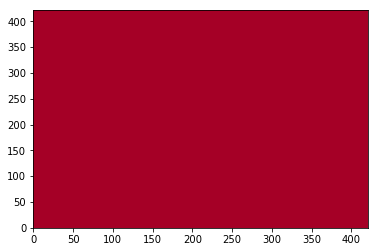

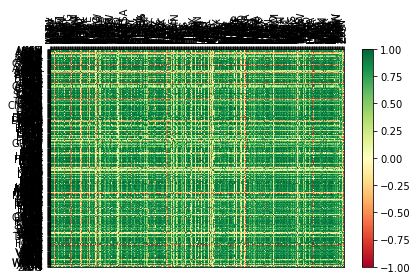

In [50]:
# Due to the high number of stocks to plot, the whole picture is messed up
# It is possible to see individual correlations if you zoom in
visualize_data()

In [63]:
# Let's create a function to plot only the first 20 names
def visualize_data20():
    df = pd.read_csv("sp500_joined_closes.csv", usecols = [*range(0, 20)])
    df_corr = df.corr()
    
    print(df_corr.head())
    
    data = df_corr.values
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    heatmap = ax.pcolor(data, cmap = plt.cm.RdYlGn)
    fig.colorbar(heatmap)
    ax.set_xticks(np.arange(data.shape[0]) + 0.5, minor = False)
    ax.set_yticks(np.arange(data.shape[1]) + 0.5, minor = False)
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    
    column_labels = df_corr.columns
    row_labels = df_corr.index
    
    ax.set_xticklabels(column_labels)
    ax.set_yticklabels(row_labels)
    plt.xticks(rotation = 90)
    heatmap.set_clim(-1, 1)
    plt.tight_layout()
    plt.show()

           MMM       ABT      ABBV       ACN      ATVI       AYI      ADBE  \
MMM   1.000000  0.947107  0.917590  0.966734  0.926806  0.962077  0.931898   
ABT   0.947107  1.000000  0.870608  0.953740  0.890623  0.903148  0.888509   
ABBV  0.917590  0.870608  1.000000  0.782810  0.740370  0.831226  0.868343   
ACN   0.966734  0.953740  0.782810  1.000000  0.939226  0.959037  0.924770   
ATVI  0.926806  0.890623  0.740370  0.939226  1.000000  0.966880  0.939472   

           AMD       AAP       AES       AET       AMG       AFL         A  \
MMM  -0.517663  0.967155 -0.281273  0.955497  0.878620  0.908991  0.602854   
ABT  -0.584959  0.956129 -0.223817  0.920646  0.914409  0.876080  0.595948   
ABBV  0.188658  0.896813  0.056811  0.905508  0.159731  0.725471  0.806842   
ACN  -0.511405  0.963566  0.040392  0.932654  0.843667  0.886364  0.925074   
ATVI -0.525560  0.908455 -0.256417  0.937844  0.759786  0.884829  0.562571   

           APD      AKAM       ALK       ALB       ARE  
MMM  

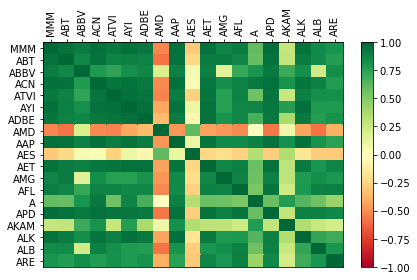

In [64]:
# We can see that AMD and AES are not strongly correlated to many other stocks
visualize_data20()

### The end